In [1]:
!pip install tf-keras-vis

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 52.5/52.5 kB 2.0 MB/s eta 0:00:00


In [2]:
import numpy as np
from matplotlib import pyplot as plt
from matplotlib import cm
import tensorflow as tf
from tf_keras_vis.gradcam import Gradcam
from tf_keras_vis.saliency import Saliency
from tf_keras_vis.utils.scores import CategoricalScore
from tf_keras_vis.utils.model_modifiers import ReplaceToLinear
from tf_keras_vis.gradcam_plus_plus import GradcamPlusPlus
from tensorflow.keras.preprocessing.image import load_img
from tensorflow.keras.applications.vgg16 import preprocess_input
from tensorflow.keras.applications.vgg16 import VGG16 as Model

Загрузим 4 изобрадения и отобразим их.

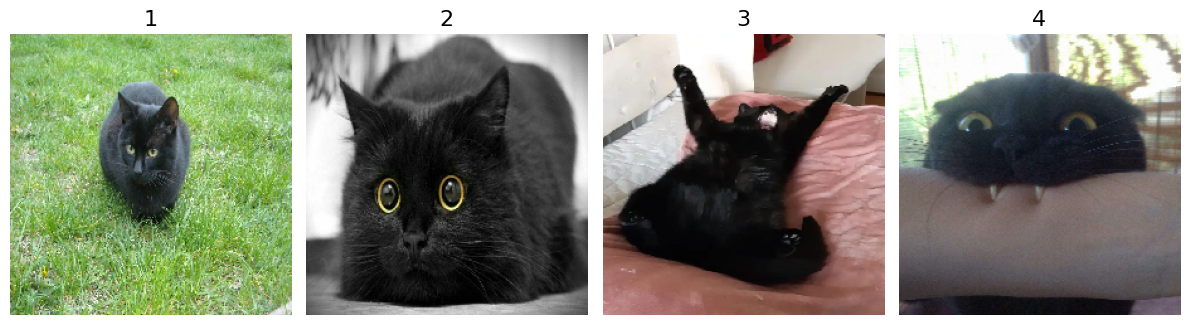

In [4]:
# Загружаем модель ResNet50 с предобученными весами на наборе данных ImageNet
model = Model(weights='imagenet', include_top=True)

# Список заголовков для изображений
imgTitleList = ['1', '2', '3', '4']

# Список путей к изображениям
imgPathList = ['1.jpg', '2.jpg', '3.jpg', '4.jpg']

# Загружаем и преобразуем изображения в массив NumPy с заданным размером (224, 224)
imgArr = np.asarray([np.array(load_img(imgPath, target_size=(224, 224))) for imgPath in imgPathList])

# Предобрабатываем изображения для подачи в модель
X = preprocess_input(imgArr)

# Создаем график с подграфиками для отображения изображений
f, ax = plt.subplots(nrows=1, ncols=4, figsize=(12, 4))
# Проходим по списку заголовков и отображаем каждое изображение
for i, title in enumerate(imgTitleList):
# Устанавливаем заголовок для подграфика
    ax[i].set_title(title, fontsize=16)
# Устанавливаем заголовок для подграфика
    ax[i].imshow(imgArr[i])
# Отключаем оси для лучшего визуального восприятия
    ax[i].axis('off')
# Настраиваем расположение подграфиков и отображаем график
plt.tight_layout()
plt.show()

ReplaceToLinear

In [5]:
# Создаем экземпляр класса ReplaceToLinear
replace2linear = ReplaceToLinear()

# Определяем функцию для изменения модели
def model_modifier_function(cloned_model):
# Меняем активацию последнего слоя модели на линейную
    cloned_model.layers[-1].activation = tf.keras.activations.linear

# Создаем объект CategoricalScore с индексом классов, которые нас интерисуют
score = CategoricalScore([41, 42, 62, 63])

# Определяем функцию для получения оценок по заданным индексам из выходного тензора модели
def score_function(output):
# Возвращаем значения выходного тензора для указанных индексов классов
    return (output[0][41], output[1][42], output[2][62], output[3][63])

Отобразим карты значимости

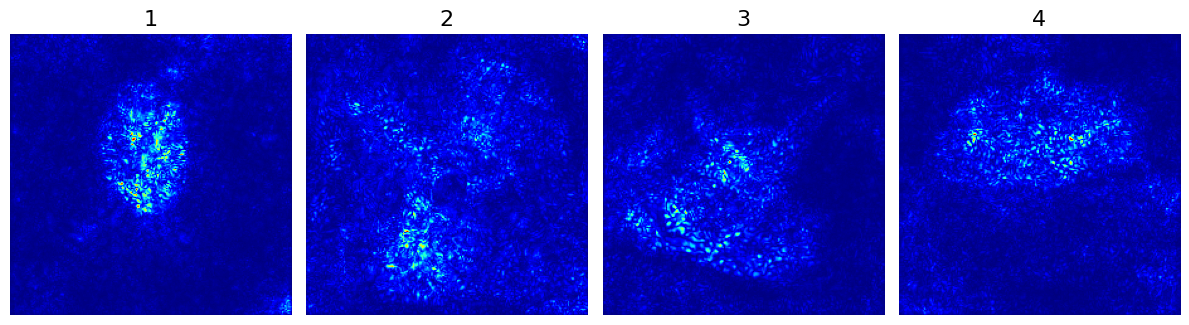

In [6]:
# Создаем объект Saliency для вычисления градиентных карт
# model - это предобученная модель, replace2linear - модификатор модели, clone=True - указывает на клонирование модели
saliency = Saliency(model,model_modifier=replace2linear,clone=True)

# Вычисляем карты значимости (saliency maps) для заданного входа X и оценок score
mapList = saliency(score, X)

# Создаем график с подграфиками для отображения карт значимости
f, ax = plt.subplots(nrows=1, ncols=4, figsize=(12, 4))
# Проходим по списку заголовков и отображаем каждую карту значимости
for i, title in enumerate(imgTitleList):
    # Устанавливаем заголовок для подграфика
    ax[i].set_title(title, fontsize=16)
    # Отображаем карту значимости с цветовой схемой 'jet'
    ax[i].imshow(mapList[i], cmap='jet')
    # Отключаем оси для лучшего визуального восприятия
    ax[i].axis('off')

# Настраиваем расположение подграфиков и отображаем график
plt.tight_layout()
plt.show()

SmoothGrad

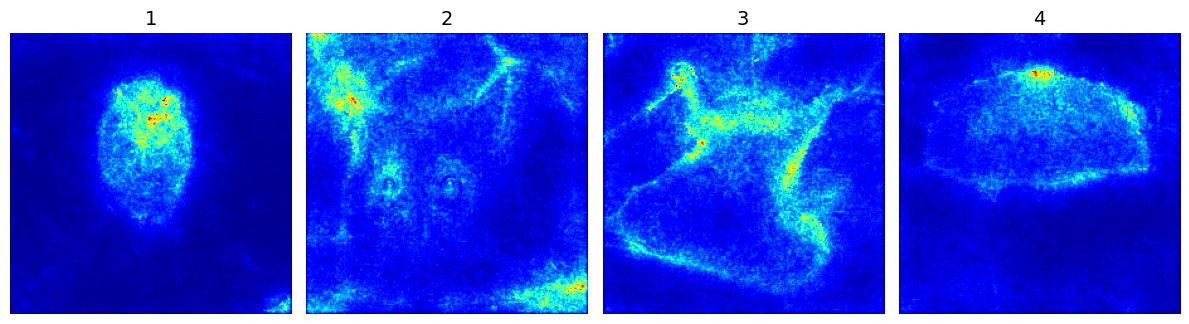

In [7]:
# Вычисляем сглаженные карты значимости с использованием указанного количества образцов и уровня шума
# smooth_samples - количество образцов для сглаживания, smooth_noise - уровень шума для добавления
mapList = saliency(score,X,smooth_samples=20,smooth_noise=0.20)

# Создаем график с подграфиками для отображения сглаженных карт значимости
f, ax = plt.subplots(nrows=1, ncols=4, figsize=(12, 4))

# Проходим по списку заголовков и отображаем каждую сглаженную карту значимости
for i, title in enumerate(imgTitleList):
    # Устанавливаем заголовок для подграфика
    ax[i].set_title(title, fontsize=14)
    # Отображаем сглаженную карту значимости с цветовой схемой 'jet'
    ax[i].imshow(mapList[i], cmap='jet')
    # Отключаем оси для лучшего визуального восприятия
    ax[i].axis('off')

# Настраиваем расположение подграфиков и отображаем график
plt.tight_layout()
plt.show()

GrandCAM

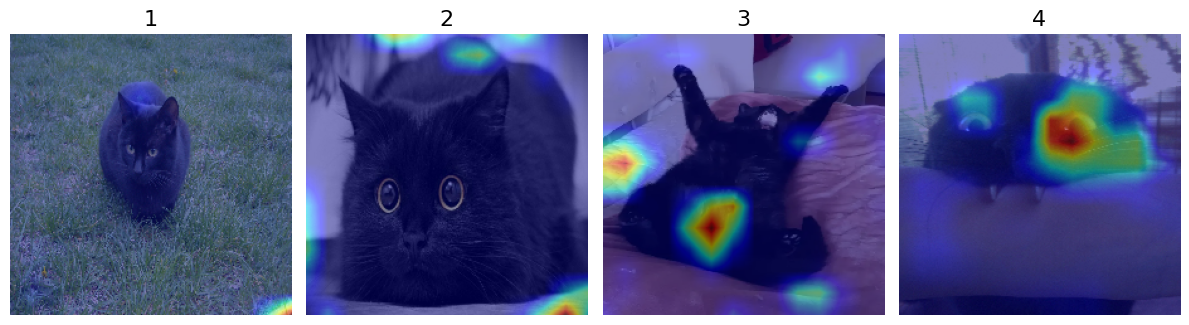

In [8]:
# Создаем объект Gradcam для вычисления карт Grad-CAM
# model - это предобученная модель, replace2linear - модификатор модели, clone=True - указывает на клонирование модели
gradcam = Gradcam(model,model_modifier=replace2linear,clone=True)

# Вычисляем карты Grad-CAM для заданного входа X и оценок score
# penultimate_layer=-1 указывает на использование последнего слоя перед выходным
mapList = gradcam(score,X,penultimate_layer=-1)

# Создаем график с подграфиками для отображения изображений и соответствующих карт Grad-CAM
f, ax = plt.subplots(nrows=1, ncols=4, figsize=(12, 4))

# Проходим по списку заголовков и отображаем каждую карту Grad-CAM
for i, title in enumerate(imgTitleList):
    # Преобразуем карту значимости в формат uint8 и масштабируем значения до 255
    heatmap = np.uint8(cm.jet(mapList[i])[..., :4] * 255)
    # Устанавливаем заголовок для подграфика
    ax[i].set_title(title, fontsize=16)
    # Отображаем оригинальное изображение
    ax[i].imshow(imgArr[i])
    # Накладываем карту Grad-CAM на изображение с прозрачностью
    ax[i].imshow(heatmap, cmap='jet', alpha=0.5)
    # Отключаем оси для лучшего визуального восприятия
    ax[i].axis('off')

# Настраиваем расположение подграфиков и отображаем график
plt.tight_layout()
plt.show()

GrandCAM++

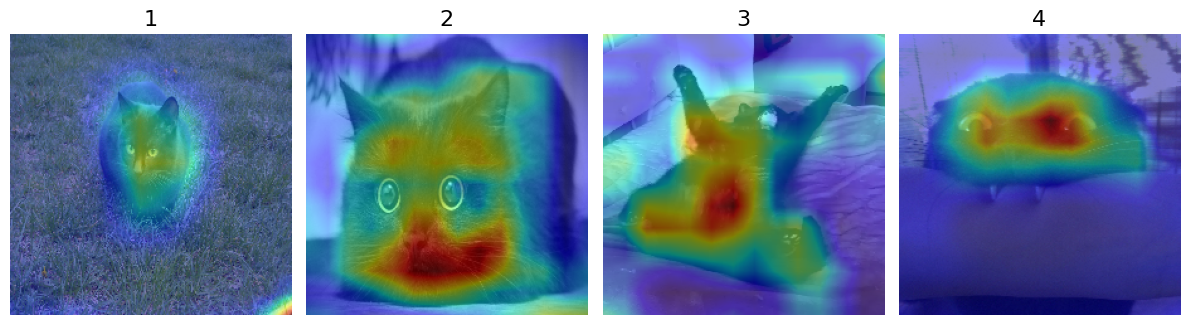

In [10]:
# Создаем объект GradcamPlusPlus для вычисления карт Grad-CAM++
# model - это предобученная модель, replace2linear - модификатор модели, clone=True - указывает на клонирование модели
gradcam = GradcamPlusPlus(model, model_modifier=replace2linear, clone=True)

# Вычисляем карты Grad-CAM++ для заданного входа X и оценок score
# penultimate_layer=-1 указывает на использование последнего слоя перед выходным
mapList = gradcam(score, X, penultimate_layer=-1)

# Создаем график с подграфиками для отображения изображений и соответствующих карт Grad-CAM++
f, ax = plt.subplots(nrows=1, ncols=4, figsize=(12, 4))

# Проходим по списку заголовков и отображаем каждую карту Grad-CAM++
for i, title in enumerate(imgTitleList):
    # Преобразуем карту значимости в формат uint8 и масштабируем значения до 255
    heatmap = np.uint8(cm.jet(mapList[i])[..., :4] * 255)
    # Устанавливаем заголовок для подграфика
    ax[i].set_title(title, fontsize=16)
    # Отображаем оригинальное изображение
    ax[i].imshow(imgArr[i])
    # Накладываем карту Grad-CAM++ на изображение с прозрачностью
    ax[i].imshow(heatmap, cmap='jet', alpha=0.5)
    # Отключаем оси для лучшего визуального восприятия
    ax[i].axis('off')

# Настраиваем расположение подграфиков и отображаем график
plt.tight_layout()
plt.show()